# Goal

In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. 

# Santander Baseline Model


**Description of data**

- Number of input variables(var_0, var_1, ... , var_199) is 200, each input variable data type is 'float' and anonymized.
- Target variable is binary variable consisting of 0, 1. 
- number of Train data rows  =  number of Train data rows


**Contents**

- EDA
- Data preprocessing 
- feature engineering
- Select input variables highly related to output variable
- Scaling 
- Split the data(train,test)
- Solution of serious imbalance problem in Y variable ex.Oversampling,Undersampling,Smote
- Modeling
- Validation
- Generate prediction value and submit

## Library

In [1]:
# Exclude error message 
import warnings
warnings.filterwarnings(action='ignore')

# Data analysis tool
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import ks_2samp
import time

# Machine Learning tool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn.decomposition import PCA
from sklearn import metrics
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import *
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasClassifier
#!pip install imblearn
from imblearn.over_sampling import SMOTE
#!pip install xgboost
from xgboost import XGBRegressor


# Visualization tool
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
plt.style.use("fivethirtyeight")
from matplotlib import rc, font_manager
mpl.rcParams['axes.unicode_minus'] = False
font_location = 'C:/Windows/Fonts/malgunbd.ttf' # 폰트 설정
font_name = fm.FontProperties(fname = font_location).get_name()
mpl.rc('font', family = font_name)
import seaborn as sns
sns.set(style="darkgrid")

seed = 110
np.random.seed(seed)

Using TensorFlow backend.


## Browse Data

In [2]:
train = pd.read_csv('Data/train.csv', engine='python', encoding='UTF-8')
test = pd.read_csv('Data/test.csv', engine='python', encoding='UTF-8')
submission = pd.read_csv('Data/sample_submission.csv', engine='python', encoding='UTF-8')

print(train.shape) # (200000, 202) / trainset has target(Y) variable
print(test.shape) # (200000, 201) / testset does not have target(Y) variable 
print(submission.shape) # (200000, 2) 

(200000, 202)
(200000, 201)
(200000, 2)


In [3]:
'''
submission form = {first column : 'ID_code', second_column = 'target'}
'''
submission.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


## EDA

In [4]:
# (Target == 0) ratio : 89.951% / (Target == 1) ratio : 10.049%  
# There is series imbalance between (Target == 0) and (Target == 1)

frequency = train['target'].value_counts(normalize = False)
ratio = train['target'].value_counts(normalize = True)
pd.DataFrame({'frequency' : frequency, 'ratio' : ratio})

,frequency,ratio
0,179902,0.89951
1,20098,0.10049


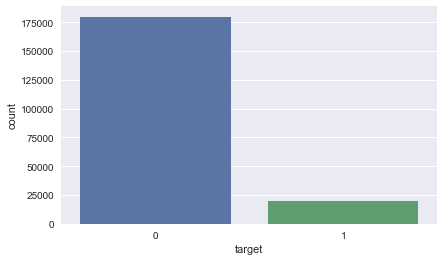

In [5]:
sns.countplot(x = 'target', data = train)

In [6]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


#### Comparison Train data variable with Test data variable  

- Train, Test 는 동일 집단에서 샘플링 된 것 확인.

In [ ]:
'''
var_list = list(train.columns[2:])

for var in var_list:
    sns.distplot(train[var])
    sns.distplot(test[var])
    plt.show()
'''

#### how much they(trainset and testset) resemble each other ####

-> Quentifing the resemblence between train variable distribution test variables distribution

* simple function using criteria 
* Kolmogorov-Smirnov Test

#### Simple function using criteria

In [8]:
train_describe = pd.DataFrame(train.describe()).iloc[1:,1:] # remove target varible, and count row
train_describe

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
mean,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,6.618800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,7.629600,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,8.584425,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,11.150600,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [9]:
test_describe = pd.DataFrame(test.describe()).iloc[1:,:] # remove count row
test_describe

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


In [10]:
def measure_resemble_train_test(train_d,test_d,criteria=0.1):
    '''
    If (data_train values - data_test values) <  criteria,
    then We can infer data_train values are close to data_test values ranging from criteria
    
    Criteria is 0.1
    
    '''
    
    k = list()
    for i in range(test_d.shape[1]):
        a = ((train_d - test_d).iloc[[0,1,3,4,5],:] < criteria).iloc[:,i:i+1].sum().values 
        k.append(a)
    return pd.Series(k)

mr = measure_resemble_train_test(train_d = train_describe,test_d = test_describe,criteria = 0.1).values.flatten()
mr

array([array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64), array([5], dtype=int64),
       array([5], dtype=int64),

In [11]:
mr2 = list()
for i in range(len(mr)):
    mr_sub = mr[i][0]
    mr2.append(mr_sub)
mr2

cri = [x == 5 for x in mr2]
cri

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 Tr

In [12]:
# 98% variables of X variables can meet simple function using criteria(0.1)
sum(cri) / len(cri) 

0.98

##### Komolgrov_Smirnov Test

 In K-S test, the distribution is assumed to be continuous and K-S test is the two-sided test.</bs>

 If the K-S statistic is small or the p-value is high, then can't reject the hypothesis that the distribution of the two samples are the same.

In [13]:
var_list = list(train.columns[2:])

w = list()
for i in var_list:
    a = ks_2samp(train[var_list][i].values,test[var_list][i].values)
    w.append(a)
print(w)   

[Ks_2sampResult(statistic=0.004325000000000023, pvalue=0.04731919978574686), Ks_2sampResult(statistic=0.003034999999999982, pvalue=0.31522455100688157), Ks_2sampResult(statistic=0.003689999999999971, pvalue=0.1310171063142887), Ks_2sampResult(statistic=0.0037950000000000483, pvalue=0.11195859358100853), Ks_2sampResult(statistic=0.003210000000000046, pvalue=0.2537769888530248), Ks_2sampResult(statistic=0.0017399999999999638, pvalue=0.9223684472570001), Ks_2sampResult(statistic=0.0036700000000000066, pvalue=0.13493110318762094), Ks_2sampResult(statistic=0.0040000000000000036, pvalue=0.08132057739505602), Ks_2sampResult(statistic=0.004209999999999936, pvalue=0.05759063341076141), Ks_2sampResult(statistic=0.0029950000000000254, pvalue=0.33061085438663557), Ks_2sampResult(statistic=0.003605000000000025, pvalue=0.14831084006640183), Ks_2sampResult(statistic=0.003314999999999957, pvalue=0.22141106958830806), Ks_2sampResult(statistic=0.005340000000000011, pvalue=0.006642183078114614), Ks_2samp

In [14]:
k = list()
for i in range(len(var_list)):
    b = w[i][1]>0.05
    k.append(b)
print("Ratio variables which meet K-S test under 5% : {}".format(sum(k)/len(var_list)))
print('--'*40)

a = train[var_list].loc[:,k].columns
print("Specific variables which meet K-S test under 5%: {}".format(a))
print('--'*40)

a2 = train[var_list].loc[:,train[var_list].columns.isin(a) == False].columns
print("Ratio variables which does not meet K-S test under 5% : {}".format(len(a2)/len(var_list)))
print('--'*40)
print("Specific variables which does not meet K-S test under 5%: {}",format(a2))

Ratio variables which meet K-S test under 5% : 0.77
--------------------------------------------------------------------------------
Specific variables which meet K-S test under 5%: Index(['var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'var_8',
       'var_9', 'var_10',
       ...
       'var_184', 'var_185', 'var_187', 'var_188', 'var_192', 'var_193',
       'var_194', 'var_196', 'var_198', 'var_199'],
      dtype='object', length=154)
--------------------------------------------------------------------------------
Ratio variables which does not meet K-S test under 5% : 0.23
--------------------------------------------------------------------------------
Specific variables which does not meet K-S test under 5%: {} Index(['var_0', 'var_12', 'var_24', 'var_26', 'var_28', 'var_32', 'var_46',
       'var_50', 'var_53', 'var_56', 'var_62', 'var_67', 'var_74', 'var_81',
       'var_82', 'var_87', 'var_88', 'var_90', 'var_91', 'var_95', 'var_100',
       'var_110', 'var_115',

#### Train 에서 Target 에 따른 변수 별 분포

In [ ]:
'''
for var in var_list:
    sns.distplot(train[train['target']==0][var])
    sns.distplot(train[train['target']==1][var])
    plt.show()
'''

## Data Preprocessing
- Deal with Nan and null value
- Deal with outlier value

In [15]:
## Train Data does not have Null value
train.isnull().sum().to_frame().sort_values(by=0, ascending=False)

,0
ID_code,0
var_136,0
var_126,0
var_127,0
var_128,0
var_129,0
var_130,0
var_131,0
var_132,0
var_133,0


In [16]:
## Test Data also does not have Null value
test.isnull().sum().to_frame().sort_values(by=0, ascending=False)

,0
ID_code,0
var_137,0
var_127,0
var_128,0
var_129,0
var_130,0
var_131,0
var_132,0
var_133,0
var_134,0


#### There is no linear correlation in train and test data

In [17]:
tr_corr = train.iloc[:,2:].corr()
tr_corr = tr_corr.values.flatten()
tr_corr = tr_corr[tr_corr != 1]
tr_corr

array([-0.0005437 ,  0.00657283,  0.00380076, ...,  0.00060689,
        0.00499055, -0.00473056])

In [18]:
print("Ratio which is of correlation of X variables in train set under 0.1 : {}".format(sum(abs(tr_corr) < 0.01) / len(tr_corr)))

Ratio which is of correlation of X variables in train set under 0.1 : 1.0


In [19]:
te_corr = test.iloc[:,1:].corr()
te_corr = te_corr.values.flatten()
te_corr = te_corr[te_corr != 1]
te_corr

array([ 0.00423351,  0.00262497,  0.00084712, ...,  0.00205493,
        0.00335979, -0.00083358])

In [20]:
print("Ratio which is of correlation of X variables in test set under 0.1 : {}".format(sum(abs(te_corr) < 0.01) / len(te_corr)))

Ratio which is of correlation of X variables in test set under 0.1 : 1.0


## Feature Engineering and Select input variables
- (1) Select important input variables
- (2) PCA(Principal Component Analysis)
- (3) Generate the index highly related to Target variable

### (1) Select input Variables

(1)-1 Processing Permutation Importance

criteria : baseline model<Wooil's Neural Network>

In [ ]:
input_col = list(train.columns)[2:]
output_col = list(train.columns)[1]

X_dataset = train[input_col]
y_dataset = train[output_col]

X_test_dataset = test[input_col]

# Split data into train and test data 
# Ratio = train : test = 8 : 2 

cutline = int(len(train)*0.8)

X_dataset_80 = X_dataset[:cutline]
X_dataset_20 = X_dataset[cutline:]

y_dataset_80 = y_dataset[:cutline]
y_dataset_20 = y_dataset[cutline:]

scaler = StandardScaler()
scaler.fit(X_dataset_80)

X_train = scaler.transform(X_dataset_80)
X_validation = scaler.transform(X_dataset_20)
X_test = scaler.transform(X_test_dataset)

y_train = y_dataset_80
y_validation = y_dataset_20

train_org = train[:cutline]
validation_org = train[cutline:]

print("Train :", len(X_train))
print("Validation :", len(X_validation))
print('Test :', len(X_test))

# SMOTE Technique for dealing with imbalance problem#
sm = SMOTE(ratio = 1, kind = 'regular', random_state = 12)
# kind = ['regular', 'borderline1', 'borderline2', 'svm']

X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of X_train: {}'.format(X_train.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))


def base_model():
    # 모델 
    model = Sequential()

    # Hidden Layer1
    model.add(Dense(400, input_dim = input_size ,init = 'glorot_normal', use_bias = True, bias_initializer = 'zeros'))
    model.add(Activation('tanh'))

    # Hidden Layer2
    model.add(Dense(400, init = 'glorot_normal'))
    model.add(Activation('tanh'))

    # Output Layer
    model.add(Dense(output_dim = 1))
    model.add(Activation('sigmoid'))

    # 모델 학습과정 설정하기
    model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy']) #rmsprop adam
    return model

clf = KerasClassifier(build_fn = base_model, epochs = epochs, batch_size = batch_size)
clf.fit(X_train,y_train)

per_importance = PermutationImportance(clf,random_state = 12).fit(X_train,y_train)

In [ ]:
per_importance

In [ ]:
eli5.show_weights(per_importance,top = 200)

(1)-2.Recursive Feature Elimination</bs>

RFE(Recursive Feature Elimination) method works by removing attributes recursively and finds which attributes are important to predict the output attribute.

(1)-3.Feature importance using Ensembles of decision trees</bs>

Ensembles of decision trees can be used to select important attributes. 

In [ ]:
# fit Extra Tree model to the train data

model = ExtraTreesClassifier(n_estimators = 100,
                             )

model.fit(train.iloc[:,2:],
          train.iloc[:,1:2])

### (2) PCA(Principal Components Analysis)

In [21]:
pca_train_x = train.iloc[:,2:].values
pca_test_x = test.iloc[:,1:].values

In [22]:
# Standardizing the features 
pca_train_x = StandardScaler().fit_transform(pca_train_x)
pca_test_x = StandardScaler().fit_transform(pca_test_x)

In [23]:
pca = PCA(n_components = 150,
          svd_solver = 'auto',
          random_state = 12)

In [24]:
principal_compo_tr = pca.fit_transform(pca_train_x)
principal_compo_te = pca.fit_transform(pca_test_x)

In [25]:
df_train = pd.DataFrame(data = principal_compo_tr,
                        columns = train.iloc[:,2:152].columns)
df_train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149
0,-0.565058,-1.286815,-0.052384,0.907197,-0.309077,-0.883561,0.166516,-0.391172,-0.053866,0.263147,...,0.790655,1.363773,-0.223893,0.471139,-0.537195,-0.245197,0.936733,-1.332775,1.019966,0.178121
1,2.495162,0.186593,0.224538,-0.009524,0.762327,-0.107675,0.920689,0.390032,-1.500828,1.429078,...,0.308173,-0.089517,-0.336982,0.916061,0.827481,-0.676124,-1.085506,-0.526134,0.773371,1.510587
2,-0.126464,-0.088453,-0.606849,-0.799541,0.816255,-0.597386,-0.251139,0.145980,-0.144911,0.751865,...,0.198300,-1.032999,-0.219104,-0.098147,0.024887,-0.878681,-0.266594,-0.324444,-0.189480,-0.575689
3,1.166322,-0.221439,1.018527,-1.048291,0.506151,-0.881075,-0.117602,-0.027276,1.245131,0.053467,...,0.126221,-1.019573,0.625304,-1.548323,-0.539651,-1.120833,2.100956,-1.086960,-1.153350,2.035715
4,0.447454,0.728456,0.428742,0.664404,-0.614091,1.211479,-0.734313,0.578402,-1.542590,-1.240075,...,-0.761264,-0.842436,-0.548476,-0.744569,-0.111326,0.483443,-1.514879,-1.092605,-1.206925,0.724841


In [26]:
df_test = pd.DataFrame(data = principal_compo_te,
                       columns = test.iloc[:,1:151].columns)
df_test.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149
0,0.185196,0.544392,0.761958,1.399017,0.876586,0.321723,-0.820455,0.178102,-0.586441,0.978557,...,1.090609,-0.669799,1.059813,1.686759,-0.854786,1.588536,-0.632784,0.440865,-1.450089,-0.009517
1,1.110500,-0.687579,0.789056,0.695684,-0.096331,1.038258,0.105293,-0.093627,-0.001096,-0.972977,...,0.896177,1.220073,1.091706,0.130185,0.489506,-0.195060,0.724590,0.670840,-0.545606,-0.901790
2,0.468404,1.576627,0.799260,1.726625,0.618498,0.042487,1.063649,-0.629277,0.248393,3.540199,...,0.405643,-0.659104,-0.629750,-1.238191,-0.172306,0.878381,-1.120614,0.818652,-0.481389,0.777516
3,0.468055,0.387864,0.661236,0.917826,-0.662956,0.447297,2.244682,0.877475,0.842288,-1.589454,...,0.026691,0.973762,-1.355145,0.617007,-0.575144,0.876817,1.273570,-1.247758,1.454953,-0.899561
4,0.348757,-1.195222,-0.723480,-0.036989,-0.527582,1.158022,0.605976,-1.058362,-0.719639,-0.085354,...,1.339941,-0.691205,-1.017586,1.897238,0.731851,0.843774,-0.332323,-0.919826,1.409617,-0.094861


In [27]:
pca_y_train = train['target']

In [28]:
df_train['target'] = pca_y_train
df_train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,target
0,-0.565058,-1.286815,-0.052384,0.907197,-0.309077,-0.883561,0.166516,-0.391172,-0.053866,0.263147,...,1.363773,-0.223893,0.471139,-0.537195,-0.245197,0.936733,-1.332775,1.019966,0.178121,0
1,2.495162,0.186593,0.224538,-0.009524,0.762327,-0.107675,0.920689,0.390032,-1.500828,1.429078,...,-0.089517,-0.336982,0.916061,0.827481,-0.676124,-1.085506,-0.526134,0.773371,1.510587,0
2,-0.126464,-0.088453,-0.606849,-0.799541,0.816255,-0.597386,-0.251139,0.145980,-0.144911,0.751865,...,-1.032999,-0.219104,-0.098147,0.024887,-0.878681,-0.266594,-0.324444,-0.189480,-0.575689,0
3,1.166322,-0.221439,1.018527,-1.048291,0.506151,-0.881075,-0.117602,-0.027276,1.245131,0.053467,...,-1.019573,0.625304,-1.548323,-0.539651,-1.120833,2.100956,-1.086960,-1.153350,2.035715,0
4,0.447454,0.728456,0.428742,0.664404,-0.614091,1.211479,-0.734313,0.578402,-1.542590,-1.240075,...,-0.842436,-0.548476,-0.744569,-0.111326,0.483443,-1.514879,-1.092605,-1.206925,0.724841,0


split full data into training and validation data

In [29]:
# split data(training : validation = 80:20)
ind = int(len(train) * 0.8)

x_train_80 = df_train[:ind]
x_train_20 = df_train[ind:]

x_train = x_train_80.iloc[:,:-1]
x_validation = x_train_20.iloc[:,:-1]

y_train = x_train_80.iloc[:,-1:]
y_validation = x_train_20.iloc[:,-1:]

### Solution of serious imbalance problem in Y variable in train data

-ex.Oversampling,Undersampling,Smote

In [64]:
sum((y_train == 1).values)[0]

16049

In [65]:
print("Before OverSampling, counts of label '1': {}".format(sum((y_train==1).values)[0])
print("Before OverSampling, counts of label '0': {} \n".format(sum((y_train==0).values)[0])

print("Before OverSampling, counts of label '1': {}".format(sum((y_validation==1).values)[0])
print("Before OverSampling, counts of label '0': {} \n".format(sum((y_validation==0).values)[0])

print("Number transactions X_train dataset: ", x_train.shape)
print("Number transactions Y_train dataset: ", y_train.shape,'\n')

print("Number transactions X_test dataset: ", x_validation.shape)
print("Number transactions Y_test dataset: ", y_validation.shape)

SyntaxError: invalid syntax (<ipython-input-65-4bec941bbfa1>, line 2)

## Modeling


Tuning the hyper-parameters

In [42]:
'''
def model_fit_h2(x_train,y_train,x_validation,y_validation,n_nodes,ke_i,bi_i,acti,optimi,n_epochs,n_batch):
    
    # n_nodes = [150,300,400,500]
    # Ke_i = 'lecun_uniform', ' lecun_noraml','glorot_normal','glorot_uniform','he_normal','he_uniform'
    # bi_i = 'Zeros', 'Ones'
    # acti : 'elu', 'selu', 'softplus', 'softsign','relu','tanh','sigmoid','hard_sigmoid','exponential'
    # optimi = 'rmsprop', 'adam' 
    # n_epochs = 10,50,100
    # n_batch = 1,100,300
    
    # Define model
    model = Sequential()
    model.add(Dense(n_nodes,
                    kernel_initializer = ke_i,
                    use_bias = True,
                    bias_initializer = bi_i,
                    activation = acti,
                    input_dim = x_train.shape[1]))
    model.add(Dense(n_nodes,
                    kernel_initializer = ke_i,
                    use_bias = True,
                    bias_initializer = bi_i,
                    activation = acti))
    model.add(Dense(output_dim = 1,activation = 'sigmoid'))
    #model.add(Activation('sigmoid'))
    model.compile(optimizer = optimi, loss = 'binary_crossentropy', metrics = ['accuracy']) 
    
    # fit model
    history = model.fit(x_train,y_train,epochs = n_epochs,batch_size = n_batch,verbose=0)
    
    # Evaluate model on test set
    _, test_acc = model.evaluate(x_validation,y_validation,verbose=0)
    return history,test_acc
'''

"\ndef model_fit_h2(x_train,y_train,x_validation,y_validation,n_nodes,ke_i,bi_i,acti,optimi,n_epochs,n_batch):\n    \n    # n_nodes = [150,300,400,500]\n    # Ke_i = 'lecun_uniform', ' lecun_noraml','glorot_normal','glorot_uniform','he_normal','he_uniform'\n    # bi_i = 'Zeros', 'Ones'\n    # acti : 'elu', 'selu', 'softplus', 'softsign','relu','tanh','sigmoid','hard_sigmoid','exponential'\n    # optimi = 'rmsprop', 'adam' \n    # n_epochs = 10,50,100\n    # n_batch = 1,100,300\n    \n    # Define model\n    model = Sequential()\n    model.add(Dense(n_nodes,\n                    kernel_initializer = ke_i,\n                    use_bias = True,\n                    bias_initializer = bi_i,\n                    activation = acti,\n                    input_dim = x_train.shape[1]))\n    model.add(Dense(n_nodes,\n                    kernel_initializer = ke_i,\n                    use_bias = True,\n                    bias_initializer = bi_i,\n                    activation = acti))\n    mode

In [43]:
'''
n_nodes = [150,300,400,500]
ke_i = ['lecun_uniform','lecun_noraml','glorot_normal','glorot_uniform','he_normal','he_uniform']
bi_i = ['Zeros','Ones']
acti = ['elu', 'selu', 'softplus', 'softsign','relu','tanh','sigmoid','hard_sigmoid','exponential']
optimi = ['rmsprop','adam']
n_epochs = [10,50,100]
n_batch = [1,100,300]

for a in n_nodes:
    for b in ke_i:
        for c in bi_i:
            for d in acti:
                for e in optimi:
                    for f in n_epochs:
                        for g in n_batch:
                            history,result = model_fit_h2(x_train,y_train,x_validation,y_validation,a,b,c,d,e,f,g)
                            print("n_nodes:{},ke_i:{},bi_i:{},acti:{},optimi:{},n_epochs:{},n_batch:{},test accuracy:{}".format(a,b,c,d,e,f,g,result))
'''

'\nn_nodes = [150,300,400,500]\nke_i = [\'lecun_uniform\',\'lecun_noraml\',\'glorot_normal\',\'glorot_uniform\',\'he_normal\',\'he_uniform\']\nbi_i = [\'Zeros\',\'Ones\']\nacti = [\'elu\', \'selu\', \'softplus\', \'softsign\',\'relu\',\'tanh\',\'sigmoid\',\'hard_sigmoid\',\'exponential\']\noptimi = [\'rmsprop\',\'adam\']\nn_epochs = [10,50,100]\nn_batch = [1,100,300]\n\nfor a in n_nodes:\n    for b in ke_i:\n        for c in bi_i:\n            for d in acti:\n                for e in optimi:\n                    for f in n_epochs:\n                        for g in n_batch:\n                            history,result = model_fit_h2(x_train,y_train,x_validation,y_validation,a,b,c,d,e,f,g)\n                            print("n_nodes:{},ke_i:{},bi_i:{},acti:{},optimi:{},n_epochs:{},n_batch:{},test accuracy:{}".format(a,b,c,d,e,f,g,result))\n'

In [49]:
start = time.time()
#======================================================================
# 모델 

def base_model(acti = 'tanh',init = 'glorot_normal',bias_initializer='zeros'): 
    model = Sequential()
    # Hidden Layer1
    model.add(Dense(300, input_dim = x_train.shape[1] ,init = 'glorot_normal', use_bias = True, bias_initializer = 'zeros'))
    model.add(Activation(acti))
    # Hidden Layer2
    model.add(Dense(300, init = 'glorot_normal'))
    model.add(Activation(acti))
    # Hidden Layer 3
    model.add(Dense(300, init = 'glorot_normal'))
    model.add(Activation(acti))
    # Output Layer
    model.add(Dense(output_dim = 1))
    model.add(Activation('sigmoid'))
    model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy']) #rmsprop adam
    return model

# Train model

a = base_model(acti='elu')

hist = a.fit(x_train, 
             y_train, 
             epochs = 20, 
             batch_size = int(len(x_train)*0.8),
             shuffle = True,
             validation_split=0.2)
#======================================================================
print('Running Time : %.02f초' % (time.time() - start))

C:\Users\lions\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, input_dim=150, use_bias=True, bias_initializer="zeros", kernel_initializer="glorot_normal")`
  
C:\Users\lions\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, kernel_initializer="glorot_normal")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\lions\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, kernel_initializer="glorot_normal")`
  
C:\Users\lions\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 128000 samples, validate on 32000 samples
Epoch 1/20
128000/128000 [==============================] - 7s 52us/step - loss: 0.8019 - acc: 0.4261 - val_loss: 0.5234 - val_acc: 0.7910
Epoch 2/20
128000/128000 [==============================] - 5s 43us/step - loss: 0.5215 - acc: 0.7922 - val_loss: 0.3820 - val_acc: 0.8923
Epoch 3/20
128000/128000 [==============================] - 6s 45us/step - loss: 0.3783 - acc: 0.8936 - val_loss: 0.3482 - val_acc: 0.8983
Epoch 4/20
128000/128000 [==============================] - 6s 44us/step - loss: 0.3427 - acc: 0.8998 - val_loss: 0.3557 - val_acc: 0.8986
Epoch 5/20
128000/128000 [==============================] - 6s 43us/step - loss: 0.3491 - acc: 0.9000 - val_loss: 0.3591 - val_acc: 0.8986
Epoch 6/20
128000/128000 [==============================] - 6s 46us/step - loss: 0.3520 - acc: 0.9000 - val_loss: 0.3479 - val_acc: 0.8987
Epoch 7/20
128000/128000 [==============================] - 6s 43us/step - loss: 0.3409 - acc: 0.9000 - val_loss: 0

Train model

## Validation


In [50]:
train_org = df_train[:ind]
validation_org = df_train[ind:]

pred_val = a.predict(x_validation)
pred = np.array(pred_val > 0.5, dtype = int)
validation_org['pred_val'] = pred_val
validation_org['pred'] = pred

CM = confusion_matrix(validation_org['pred'], validation_org['target'])

sensitivity = CM[1,1]/(CM[0,1] + CM[1,1])
precision = CM[1,1]/(CM[1,0] + CM[1,1])
f1_measure = 2*(sensitivity*precision) / (sensitivity+precision)
beta = 2
fn_measure = (1 + (beta**2))*(sensitivity*precision) / (((beta**2)*precision)+sensitivity)

R_F_sum = CM[0,1] + CM[1,1]
R_P_sum = CM[0,0] + CM[1,0]
Accuracy = (CM[0,0] + CM[1,1])/(R_F_sum + R_P_sum)

print(CM)
print("Accuracy :", round(Accuracy,4))
print("Sensitivity :", round(sensitivity,4))
print("Precision :", round(precision,4))
print("F1-Measure :", round(f1_measure,4))
print("F2-Measure :", round(fn_measure,4))

[[35476  3325]
 [  475   724]]
Accuracy : 0.905
Sensitivity : 0.1788
Precision : 0.6038
F1-Measure : 0.2759
F2-Measure : 0.2081


AUC Score Check (with validation data)

In [51]:
auc_score = roc_auc_score(validation_org['target'], validation_org['pred_val'])
print('AUC Score :', auc_score)

AUC Score : 0.8161793879610251


In [54]:
validation_org['pred_val']

160000    0.004940
160001    0.027923
160002    0.077302
160003    0.136503
160004    0.018992
160005    0.019176
160006    0.009856
160007    0.061049
160008    0.049936
160009    0.061051
160010    0.031351
160011    0.006619
160012    0.044182
160013    0.079974
160014    0.077037
160015    0.208605
160016    0.056972
160017    0.133358
160018    0.022494
160019    0.050360
160020    0.001307
160021    0.038319
160022    0.078318
160023    0.035448
160024    0.040323
160025    0.005035
160026    0.101433
160027    0.000865
160028    0.001972
160029    0.027642
            ...   
199970    0.190505
199971    0.495408
199972    0.104790
199973    0.045145
199974    0.018430
199975    0.001805
199976    0.018828
199977    0.117282
199978    0.062786
199979    0.287235
199980    0.055603
199981    0.196585
199982    0.029285
199983    0.005112
199984    0.000499
199985    0.004702
199986    0.441849
199987    0.000130
199988    0.005540
199989    0.003014
199990    0.167535
199991    0.

## Generate prediction value

In [ ]:
pred_val = model.predict(X_test)
pred = np.array(pred_val > 0.5, dtype = int)

submission['pred_val'] = pred_val
submission['pred'] = pred